In [1]:
import igraph as ig
import sknetwork as sn
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import adjusted_mutual_info_score as AMI
from sklearn.metrics import roc_auc_score as AUC
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score, accuracy_score, recall_score
from tqdm import trange, tqdm

from itertools import product
import sys
import os
sys.path.append('../')
from CAS import *

import ECG.ecg_sknetwork as ecg_sn
import ecg_igraph as ecg_igraph

## Generate ABCD+o graphs using Julia

In [2]:
# ABCD+o only in Julia for now - update path below as needed

## local:
# abcd_path = '/Users/francois/ABCD/ABCDo/ABCDGraphGenerator.jl/utils/'
# julia = '/Applications/Julia-1.7.app/Contents/Resources/julia/bin/julia '

## Dev02:
abcd_path = '/home/rdewolfe/research/ABCDGraphGenerator.jl/utils/'
julia = '/home/rdewolfe/.juliaup/bin/julia '

def _run_julia_abcd(n=1000, xi=0.3, delta=5, zeta=0.5, gamma=2.5, s=25, tau=0.825, beta=1.5, seed=123, nout=0):
    D = int(n**zeta)
    S = int(n**tau) 
    rdm = str(np.random.choice(100000))
    fn_deg = 'deg_'+rdm+'.dat'
    fn_cs = 'cs_'+rdm+'.dat'
    fn_comm = 'comm_'+rdm+'.dat'
    fn_net = 'net_'+rdm+'.dat'
    ## generate graph
    cmd = julia+abcd_path+'deg_sampler.jl '+fn_deg+' '+str(gamma)+' '+str(delta)+' '+str(D)+' '+str(n)+' 1000 '+str(seed)
    os.system(cmd+' >/dev/null 2>&1')
    cmd = julia+abcd_path+'com_sampler.jl '+fn_cs+' '+str(beta)+' '+str(s)+' '+str(S)+' '+str(n)+' 1000 '+str(seed)+' '+str(nout)
    os.system(cmd+' >/dev/null 2>&1')
    cmd = julia+abcd_path+'graph_sampler.jl '+fn_net+' '+fn_comm+' '+fn_deg+' '+fn_cs+' xi '+str(xi)+' false false '+str(seed)+' '+str(nout)
    os.system(cmd+' >/dev/null 2>&1')
    ## load edges
    edges = np.loadtxt(fn_net, dtype='int32')
    g = sn.data.from_edge_list(edges - 1)  # Make 0 indexed
    ## ground-truth communities
    c = np.loadtxt(fn_comm,dtype='int32',usecols=(1))
    c = c-1  # make 0 indexed
    cmd = 'rm *_'+rdm+'.dat'
    os.system(cmd+' >/dev/null 2>&1')
    return g, c

In [5]:
g, gt = _run_julia_abcd(10000, 0.5, nout=200)

In [6]:
%%time
ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.p_to_cluster)

CPU times: user 3.59 s, sys: 199 ms, total: 3.79 s
Wall time: 3.8 s


array([0.88008489, 0.8706009 , 0.01832507, ..., 0.874593  , 0.95017545,
       0.24894815])

In [11]:
weights = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.p_to_cluster)
coms = ecg_sn.cluster_edges(g, weights)
o_out, c_out = ecg_sn.attatchment_scores(g.indptr, g.indices, weights, coms)

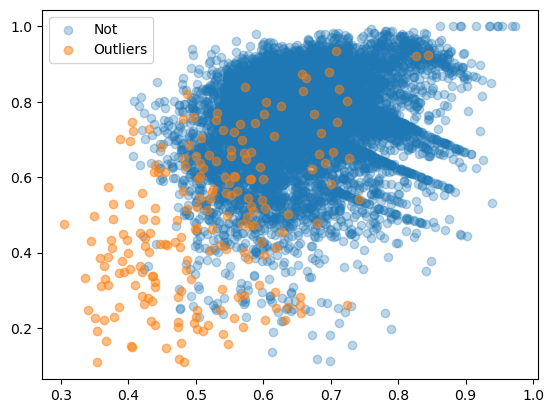

In [12]:
is_outlier = gt == 0
plt.scatter(o_out[~is_outlier], c_out[~is_outlier], label="Not", alpha=0.3)
plt.scatter(o_out[is_outlier], c_out[is_outlier], label="Outliers", alpha=0.5)
plt.legend()

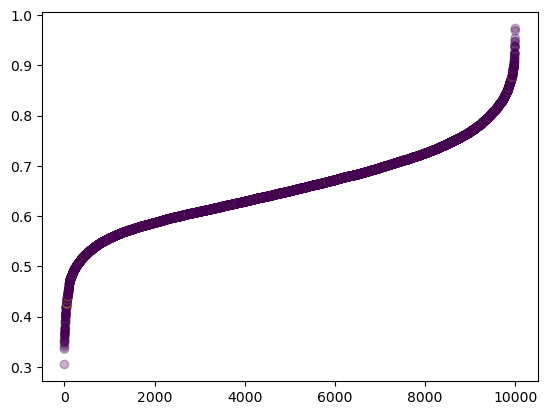

In [15]:
plt.scatter(np.arange(len(o_out)), np.sort(o_out), c=is_outlier, alpha=0.3)

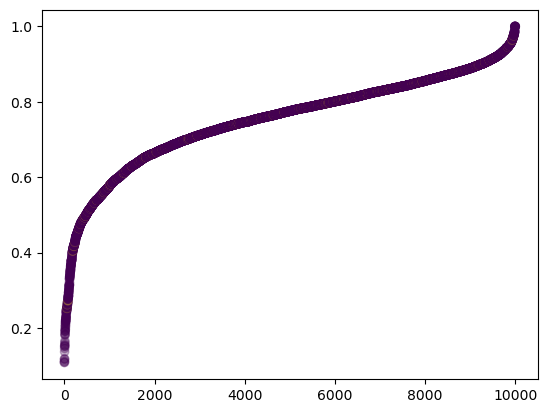

In [16]:
plt.scatter(np.arange(len(c_out)), np.sort(c_out), c=is_outlier, alpha=0.3)

In [27]:
%load_ext autoreload
%autoreload 2

In [43]:
%%time
s = ecg_sn.get_scores(g.indptr, g.indices, weights, coms, "nief")

CPU times: user 654 ms, sys: 12 ms, total: 666 ms
Wall time: 665 ms


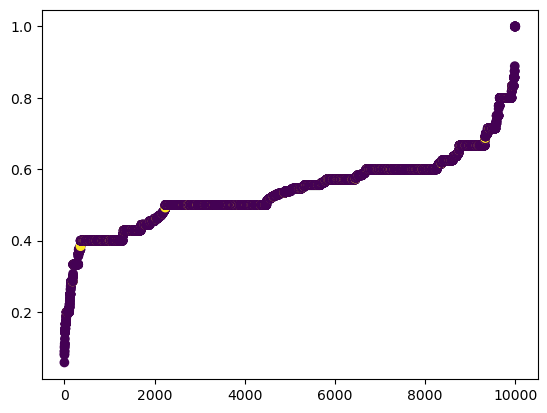

In [44]:
plt.scatter(np.arange(len(s)), np.sort(s), c=is_outlier)

CPU times: user 1min 6s, sys: 152 ms, total: 1min 7s
Wall time: 1min 6s


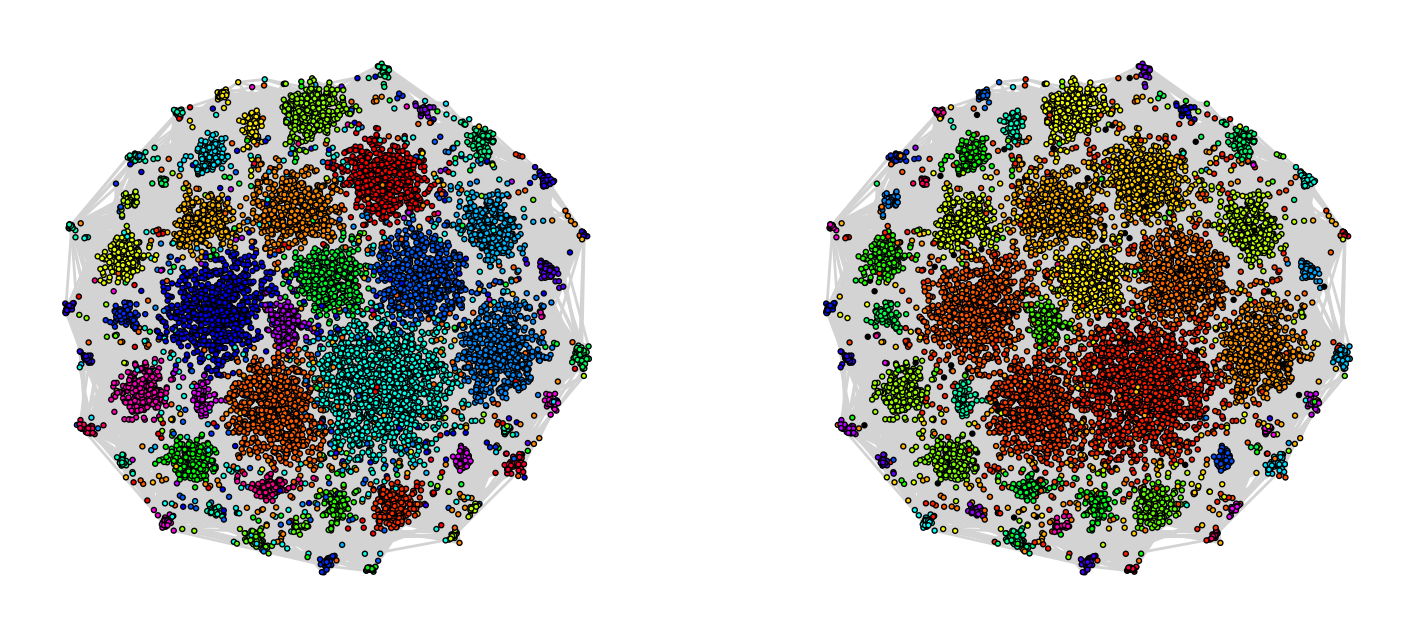

In [165]:
%%time
ly = g.layout_umap()
fig, axs = plt.subplots(1, 2, figsize=(18, 8))

pal = ig.RainbowPalette(n=np.max(coms)+1) 
g.vs['color'] = [pal.get(int(i)) for i in coms]
ig.plot(g, layout=ly, edge_color="lightgray", target=axs[0], vertex_size=5)

pal = ig.RainbowPalette(n=max(g.vs["gt"])+1) 
g.vs['color'] = [pal.get(int(i)) if i>0 else (0, 0, 0) for i in g.vs["gt"]]
ig.plot(g, layout=ly, edge_color="lightgray", target=axs[1], vertex_size=5)

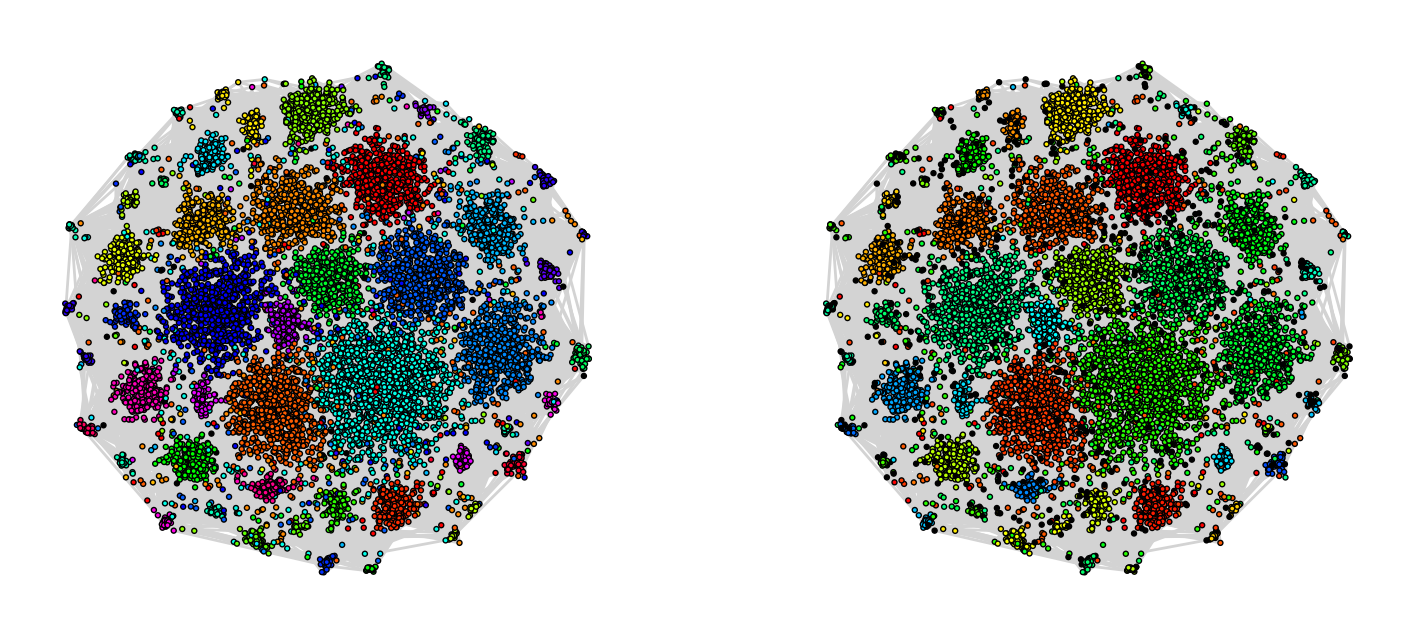

In [166]:
fig, axs = plt.subplots(1, 2, figsize=(18, 8))

dropped_outliers = np.array(coms)
dropped_outliers[c_out> 0.75] = -1
pal = ig.RainbowPalette(n=np.max(coms)+1) 
g.vs['color'] = [pal.get(int(i)) if i>=0 else (0, 0, 0) for i in dropped_outliers]
ig.plot(g, layout=ly, edge_color="lightgray", target=axs[0], vertex_size=5)

dropped_outliers = np.array(coms)
dropped_outliers[c_out> 0.5] = -1
pal = ig.RainbowPalette(n=max(g.vs["gt"])+1) 
g.vs['color'] = [pal.get(int(i)) if i>=0 else (0, 0, 0) for i in dropped_outliers]
ig.plot(g, layout=ly, edge_color="lightgray", target=axs[1], vertex_size=5)

## Experimenting on Optimal cout cut value

- Test graph size, noise level, percent outliers


In [ ]:
n = 10000
pouts = [.01, .05, .1, .3, .5]
xis = [.4, .45, .5, .55, .6]
REP = 5

data = []
pbar = tqdm(total=len(pouts)*len(xis)*REP)
for pout, xi, rep in product(pouts, xis, range(REP)):
    g = _run_julia_abcd(n=n, nout=int(n*pout), xi=xi)
    ief_weights, beta_weights, c_weigths, p_weights, ecg_weights = ecg_igraph.ensemble_cas_edge_weights(g)
    coms = ecg_igraph.cluster_edges(g, p_weights).membership
    _, p_cout = ecg_igraph.outlier_scores(g, p_weights, coms)
    _, beta_cout = ecg_igraph.outlier_scores(g, beta_weights, coms)

    data.append([n, xi, pout, rep, "gt", np.array(g.vs["gt"])])
    data.append([n, xi, pout, rep, "clustering", coms])

    data.append([n, xi, pout, rep, "p_cout", p_cout])
    data.append([n, xi, pout, rep, "beta_cout", beta_cout])

    ief, beta, c, p, degs = CAS(g.get_adjacency_sparse(), partition2sparse(coms))
    data.append([n, xi, pout, rep, "p", get_com_score(p, coms)])
    data.append([n, xi, pout, rep, "beta", get_com_score(beta, coms)])

    pbar.update()
pbar.close()

df = pd.DataFrame(data, columns=['n', 'xi', 'pout', 'rep', 'thing', 'value'])
df.to_feather("outlier_bench.feather")

  0%|          | 0/125 [00:39<?, ?it/s]


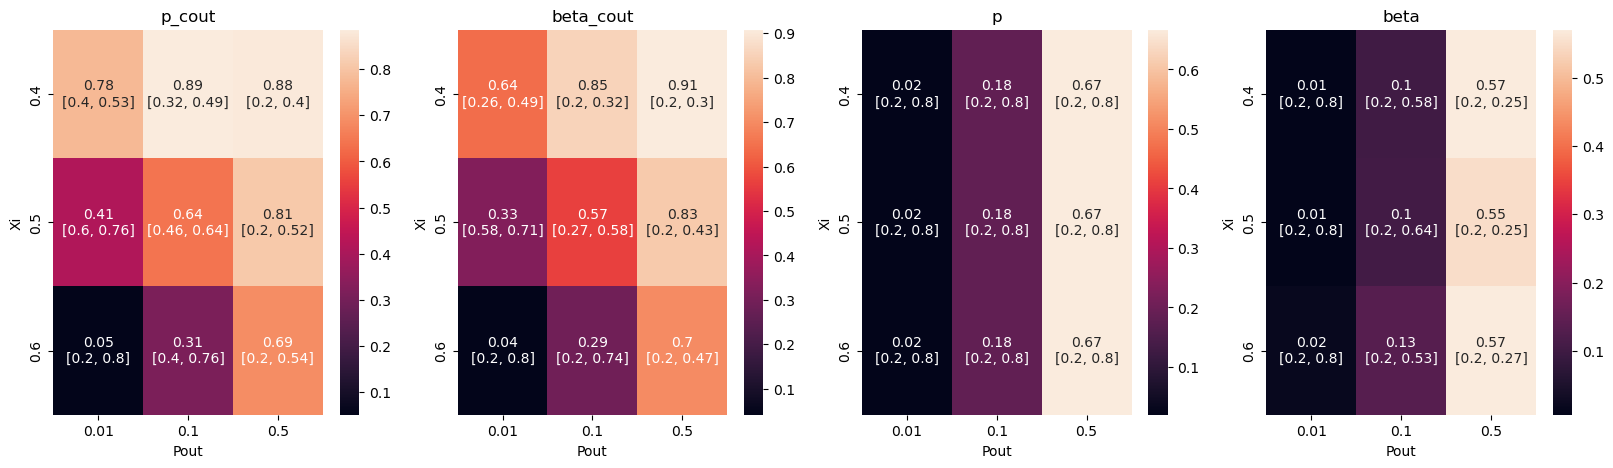

In [ ]:
rep = 1
xis = df['xi'].unique()
pouts = df['pout'].unique()
cuts = np.linspace(0.2, 0.8, 50)


def get_value(df, n, xi, pout, rep, thing):
    return df.loc[(df['n']==n) & (df['xi']==xi) & (df['pout']==pout) & (df['rep']==rep) & (df['thing']==thing)]["value"].values[0]


def get_interval(cuts, f1s, leeway=0.1):
    best = np.argmax(f1s)
    left = best
    if left != 0:
        while f1s[left-1] > f1s[best] - leeway:
            left -= 1
            if left == 0:
                break
    right = best
    if right != len(f1s) - 1:
        while f1s[right+1] > f1s[best] - leeway:
            right += 1
            if right == len(f1s)-1:
                break
    return cuts[left], cuts[right]


fig, axs = plt.subplots(2, 2, figsize=(12, 12))
axs = axs.flatten()
for i, method in enumerate(['p_cout', 'beta_cout', 'p', 'beta']):
    best_f1 = np.empty((len(xis), len(pouts)))
    left = np.empty_like(best_f1)
    right = np.empty_like(best_f1)
    for j, xi in enumerate(xis):
        for k, pout in enumerate(pouts):
            gt = get_value(df, n, xi, pout, rep, "gt") == 0
            scores = get_value(df, n, xi, pout, rep, method)
            f1s = np.empty_like(cuts)
            for p, cut in enumerate(cuts):
                f1s[p] = f1_score(gt, scores > cut)
            best_f1[j, k] = np.max(f1s)
            l, r = get_interval(cuts, f1s)
            left[j, k] = l
            right[j, k] = r
    
    frame = pd.DataFrame(best_f1, index=xis, columns=pouts)
    labels = []
    for j in range(best_f1.shape[0]):
        l = []
        for k in range(best_f1.shape[1]):
            l.append(f"{round(best_f1[j, k], 2)}\n[{round(left[j, k], 2)}, {round(right[j, k], 2)}]")
        labels.append(l)
    labels = np.asarray(labels)
    sns.heatmap(frame, ax=axs[i], annot=labels, fmt="")
    axs[i].set_title(method)
    axs[i].set_ylabel('Xi')
    axs[i].set_xlabel('Pout')

## Reults from p_cout / beta_cout. P seems to be doing better. When the task is easier/ best performance seems like it normally happens around a 0.5-0.6 threshhold.

I think this is a pretty nice graphic. Especially if we include recursive pruning socre too. But it's getting computationally expensive.

Switching to real graphs. We can revisit and run a larger benchmark if it's of interest.

## If we prune (and recalculate) up to a moderate threshhold does it prune the whole graph?

In [102]:
%%time
n = 5000
g, gt = _run_julia_abcd(n, xi=0.55, nout=1000)
w = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.p_to_cluster)
coms = ecg_sn.cluster_edges(g, w)

CPU times: user 841 ms, sys: 5 μs, total: 841 ms
Wall time: 5.71 s


In [103]:
#%%time
#ecg_sn.prune(g, coms, 0.5, edge_weights=w)


100%|██████████| 510/510 [03:07<00:00,  2.73it/s]


Non-pruned AMI 0.9691789189148283


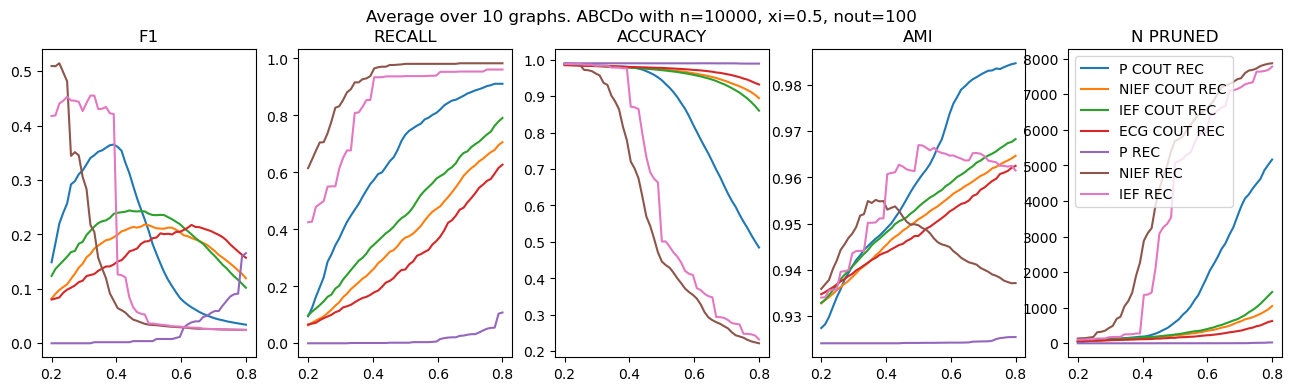

In [3]:
# Params
REP = 10
n = 10000
nout = int(n * 0.01)
xi = 0.50
cuts = np.linspace(0.2, 0.8, 51)

# Initialize results storage
pcout_pruned_rec = np.empty((REP, len(cuts), n), dtype="bool")
niefcout_pruned_rec = np.empty((REP, len(cuts), n), dtype="bool")
iefcout_pruned_rec = np.empty((REP, len(cuts), n), dtype="bool")
ecgcout_pruned_rec = np.empty((REP, len(cuts), n), dtype="bool")

pcout_pruned_one = np.empty((REP, len(cuts), n), dtype="bool")
niefcout_pruned_one = np.empty((REP, len(cuts), n), dtype="bool")
iefcout_pruned_one = np.empty((REP, len(cuts), n), dtype="bool")
ecgcout_pruned_one = np.empty((REP, len(cuts), n), dtype="bool")

p_pruned_rec = np.empty((REP, len(cuts), n), dtype="bool")
nief_pruned_rec = np.empty((REP, len(cuts), n), dtype="bool")
ief_pruned_rec = np.empty((REP, len(cuts), n), dtype="bool")

p_pruned_one = np.empty((REP, len(cuts), n), dtype="bool")
nief_pruned_one = np.empty((REP, len(cuts), n), dtype="bool")
ief_pruned_one = np.empty((REP, len(cuts), n), dtype="bool")

gts = np.empty((REP, n), dtype="int32")
com = np.empty((REP, n), dtype="int32")

# Compute
with tqdm(total=REP*len(cuts)) as pbar:
    for rep in range(REP):
        g, gt = _run_julia_abcd(n=n, xi=xi, nout=nout)
        gts[rep, :] = gt

        ief = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.ief_to_cluster)
        nief = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.nief_to_cluster)
        p = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.p_to_cluster)
        ecg = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.ecg_to_cluster)

        coms = ecg_sn.cluster_edges(g, p)
        com[rep, :] = coms

        for i, c in enumerate(cuts):
            iefcout_pruned_rec[rep, i, :] = ecg_sn.prune(g, coms, c, score="cout", edge_weights=ief)
            niefcout_pruned_rec[rep, i, :] = ecg_sn.prune(g, coms, c, score="cout", edge_weights=nief)
            pcout_pruned_rec[rep, i, :] = ecg_sn.prune(g, coms, c, score="cout", edge_weights=p)
            ecgcout_pruned_rec[rep, i, :] = ecg_sn.prune(g, coms, c, score="cout", edge_weights=ecg)

            iefcout_pruned_one[rep, i, :] = ecg_sn.prune(g, coms, c, score="cout", max_per_round=n, recursive=False, edge_weights=ief)
            niefcout_pruned_one[rep, i, :] = ecg_sn.prune(g, coms, c, score="cout", max_per_round=n, recursive=False, edge_weights=nief)
            pcout_pruned_one[rep, i, :] = ecg_sn.prune(g, coms, c, score="cout", max_per_round=n, recursive=False, edge_weights=p)
            ecgcout_pruned_one[rep, i, :] = ecg_sn.prune(g, coms, c, score="cout", max_per_round=n, recursive=False, edge_weights=ecg)

            ief_pruned_rec[rep, i, :] = ecg_sn.prune(g, coms, c, score="ief", max_per_round=100)
            nief_pruned_rec[rep, i, :] = ecg_sn.prune(g, coms, c, score="nief", max_per_round=100)
            p_pruned_rec[rep, i, :] = ecg_sn.prune(g, coms, c, score="p", max_per_round=100)

            ief_pruned_one[rep, i, :] = ecg_sn.prune(g, coms, c, score="ief", max_per_round=n, recursive=False)
            nief_pruned_one[rep, i, :] = ecg_sn.prune(g, coms, c, score="nief", max_per_round=n, recursive=False)
            p_pruned_one[rep, i, :] = ecg_sn.prune(g, coms, c, score="p", max_per_round=n, recursive=False)
        
            pbar.update()


###############
# Plot scores #
###############
def make_scores(score_function, pruned, gt, coms):
    results = np.empty((pruned.shape[0], pruned.shape[1]))
    for rep in range(pruned.shape[0]):
        is_outlier = gt[rep, :] == 0
        for i in range(pruned.shape[1]):
            results[rep, i] = score_function(is_outlier, pruned[rep, i, :])
    return results


def make_ami_scores(pruned, gt, coms):
    results = np.empty((pruned.shape[0], pruned.shape[1]))
    for rep in range(pruned.shape[0]):
        for i in range(pruned.shape[1]):
            is_outlier_or_pruned = np.bitwise_or(gt[rep, :] == 0, pruned[rep, i, :])
            results[rep, i] = AMI(gt[rep, :][~is_outlier_or_pruned], coms[rep, :][~is_outlier_or_pruned])
    return results


options = [
    [pcout_pruned_rec, "P COUT REC"],
    [niefcout_pruned_rec, "NIEF COUT REC"],
    [iefcout_pruned_rec, "IEF COUT REC"],
    [ecgcout_pruned_rec, "ECG COUT REC"],
    #[pcout_pruned_one, "P COUT"],
    #[niefcout_pruned_one, "NIEF COUT"],
    #[iefcout_pruned_one, "IEF COUT"],
    #[ecgcout_pruned_one, "ECG COUT"],
    [p_pruned_rec, "P REC"],
    [nief_pruned_rec, "NIEF REC"],
    [ief_pruned_rec, "IEF REC"],
    #[p_pruned_one, "P"],
    #[nief_pruned_one, "NIEF"],
    #[ief_pruned_one, "IEF"],
]
fig, axs = plt.subplots(1, 5, figsize=(16, 4))
for pruned, name in options:

    f1 = np.mean(make_scores(f1_score, pruned, gts, com), axis=0)
    recall = np.mean(make_scores(recall_score, pruned, gts, com), axis=0)
    accuracy = np.mean(make_scores(accuracy_score, pruned, gts, com), axis=0)
    ami = np.mean(make_ami_scores(pruned, gts, com), axis=0)

    axs[0].plot(cuts, f1, label=name)
    axs[0].set_title("F1")

    axs[1].plot(cuts, recall, label=name)
    axs[1].set_title("RECALL")

    axs[2].plot(cuts, accuracy, label=name)
    axs[2].set_title("ACCURACY")

    axs[3].plot(cuts, ami, label=name)
    axs[3].set_title("AMI")

    axs[4].plot(cuts, [np.sum(p) for p in pruned[rep, :, :]], label=name)
    axs[4].set_title("N PRUNED")
    axs[4].legend()
plt.suptitle(f"Average over {REP} graphs. ABCDo with n={n}, xi={xi}, nout={nout}")
print("Non-pruned AMI", AMI(gt[~gt], coms[~gt]))


100%|██████████| 510/510 [03:38<00:00,  2.33it/s]


Non-pruned AMI 0.9381303856575299


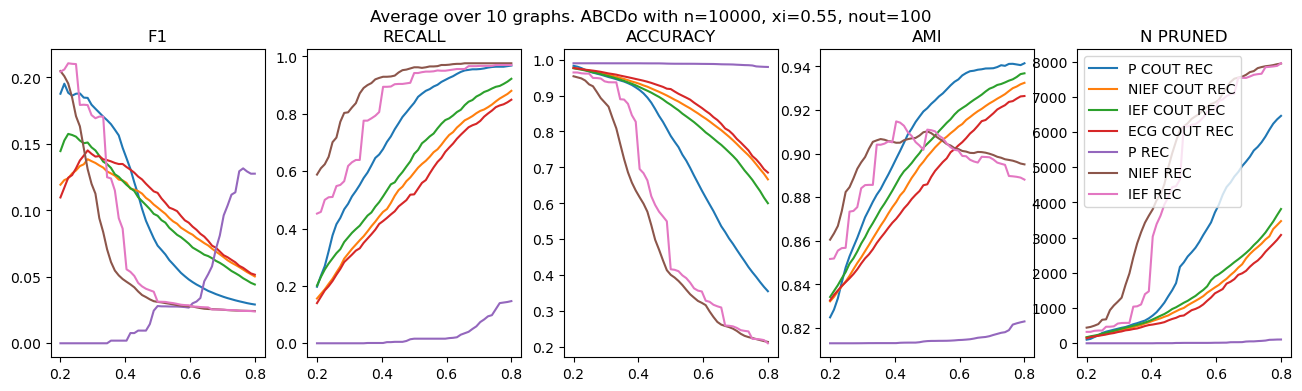

In [4]:
# Params
REP = 10
n = 10000
nout = int(n * 0.01)
xi = 0.55
cuts = np.linspace(0.2, 0.8, 51)

# Initialize results storage
pcout_pruned_rec = np.empty((REP, len(cuts), n), dtype="bool")
niefcout_pruned_rec = np.empty((REP, len(cuts), n), dtype="bool")
iefcout_pruned_rec = np.empty((REP, len(cuts), n), dtype="bool")
ecgcout_pruned_rec = np.empty((REP, len(cuts), n), dtype="bool")

pcout_pruned_one = np.empty((REP, len(cuts), n), dtype="bool")
niefcout_pruned_one = np.empty((REP, len(cuts), n), dtype="bool")
iefcout_pruned_one = np.empty((REP, len(cuts), n), dtype="bool")
ecgcout_pruned_one = np.empty((REP, len(cuts), n), dtype="bool")

p_pruned_rec = np.empty((REP, len(cuts), n), dtype="bool")
nief_pruned_rec = np.empty((REP, len(cuts), n), dtype="bool")
ief_pruned_rec = np.empty((REP, len(cuts), n), dtype="bool")

p_pruned_one = np.empty((REP, len(cuts), n), dtype="bool")
nief_pruned_one = np.empty((REP, len(cuts), n), dtype="bool")
ief_pruned_one = np.empty((REP, len(cuts), n), dtype="bool")

gts = np.empty((REP, n), dtype="int32")
com = np.empty((REP, n), dtype="int32")

# Compute
with tqdm(total=REP*len(cuts)) as pbar:
    for rep in range(REP):
        g, gt = _run_julia_abcd(n=n, xi=xi, nout=nout)
        gts[rep, :] = gt

        ief = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.ief_to_cluster)
        nief = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.nief_to_cluster)
        p = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.p_to_cluster)
        ecg = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.ecg_to_cluster)

        coms = ecg_sn.cluster_edges(g, p)
        com[rep, :] = coms

        for i, c in enumerate(cuts):
            iefcout_pruned_rec[rep, i, :] = ecg_sn.prune(g, coms, c, score="cout", edge_weights=ief)
            niefcout_pruned_rec[rep, i, :] = ecg_sn.prune(g, coms, c, score="cout", edge_weights=nief)
            pcout_pruned_rec[rep, i, :] = ecg_sn.prune(g, coms, c, score="cout", edge_weights=p)
            ecgcout_pruned_rec[rep, i, :] = ecg_sn.prune(g, coms, c, score="cout", edge_weights=ecg)

            iefcout_pruned_one[rep, i, :] = ecg_sn.prune(g, coms, c, score="cout", max_per_round=n, recursive=False, edge_weights=ief)
            niefcout_pruned_one[rep, i, :] = ecg_sn.prune(g, coms, c, score="cout", max_per_round=n, recursive=False, edge_weights=nief)
            pcout_pruned_one[rep, i, :] = ecg_sn.prune(g, coms, c, score="cout", max_per_round=n, recursive=False, edge_weights=p)
            ecgcout_pruned_one[rep, i, :] = ecg_sn.prune(g, coms, c, score="cout", max_per_round=n, recursive=False, edge_weights=ecg)

            ief_pruned_rec[rep, i, :] = ecg_sn.prune(g, coms, c, score="ief", max_per_round=100)
            nief_pruned_rec[rep, i, :] = ecg_sn.prune(g, coms, c, score="nief", max_per_round=100)
            p_pruned_rec[rep, i, :] = ecg_sn.prune(g, coms, c, score="p", max_per_round=100)

            ief_pruned_one[rep, i, :] = ecg_sn.prune(g, coms, c, score="ief", max_per_round=n, recursive=False)
            nief_pruned_one[rep, i, :] = ecg_sn.prune(g, coms, c, score="nief", max_per_round=n, recursive=False)
            p_pruned_one[rep, i, :] = ecg_sn.prune(g, coms, c, score="p", max_per_round=n, recursive=False)
        
            pbar.update()


###############
# Plot scores #
###############
def make_scores(score_function, pruned, gt, coms):
    results = np.empty((pruned.shape[0], pruned.shape[1]))
    for rep in range(pruned.shape[0]):
        is_outlier = gt[rep, :] == 0
        for i in range(pruned.shape[1]):
            results[rep, i] = score_function(is_outlier, pruned[rep, i, :])
    return results


def make_ami_scores(pruned, gt, coms):
    results = np.empty((pruned.shape[0], pruned.shape[1]))
    for rep in range(pruned.shape[0]):
        for i in range(pruned.shape[1]):
            is_outlier_or_pruned = np.bitwise_or(gt[rep, :] == 0, pruned[rep, i, :])
            results[rep, i] = AMI(gt[rep, :][~is_outlier_or_pruned], coms[rep, :][~is_outlier_or_pruned])
    return results


options = [
    [pcout_pruned_rec, "P COUT REC"],
    [niefcout_pruned_rec, "NIEF COUT REC"],
    [iefcout_pruned_rec, "IEF COUT REC"],
    [ecgcout_pruned_rec, "ECG COUT REC"],
    #[pcout_pruned_one, "P COUT"],
    #[niefcout_pruned_one, "NIEF COUT"],
    #[iefcout_pruned_one, "IEF COUT"],
    #[ecgcout_pruned_one, "ECG COUT"],
    [p_pruned_rec, "P REC"],
    [nief_pruned_rec, "NIEF REC"],
    [ief_pruned_rec, "IEF REC"],
    #[p_pruned_one, "P"],
    #[nief_pruned_one, "NIEF"],
    #[ief_pruned_one, "IEF"],
]
fig, axs = plt.subplots(1, 5, figsize=(16, 4))
for pruned, name in options:

    f1 = np.mean(make_scores(f1_score, pruned, gts, com), axis=0)
    recall = np.mean(make_scores(recall_score, pruned, gts, com), axis=0)
    accuracy = np.mean(make_scores(accuracy_score, pruned, gts, com), axis=0)
    ami = np.mean(make_ami_scores(pruned, gts, com), axis=0)

    axs[0].plot(cuts, f1, label=name)
    axs[0].set_title("F1")

    axs[1].plot(cuts, recall, label=name)
    axs[1].set_title("RECALL")

    axs[2].plot(cuts, accuracy, label=name)
    axs[2].set_title("ACCURACY")

    axs[3].plot(cuts, ami, label=name)
    axs[3].set_title("AMI")

    axs[4].plot(cuts, [np.sum(p) for p in pruned[rep, :, :]], label=name)
    axs[4].set_title("N PRUNED")
    axs[4].legend()
plt.suptitle(f"Average over {REP} graphs. ABCDo with n={n}, xi={xi}, nout={nout}")
print("Non-pruned AMI", AMI(gt[~gt], coms[~gt]))

100%|██████████| 510/510 [04:17<00:00,  1.98it/s]


Non-pruned AMI 0.7157959633773276


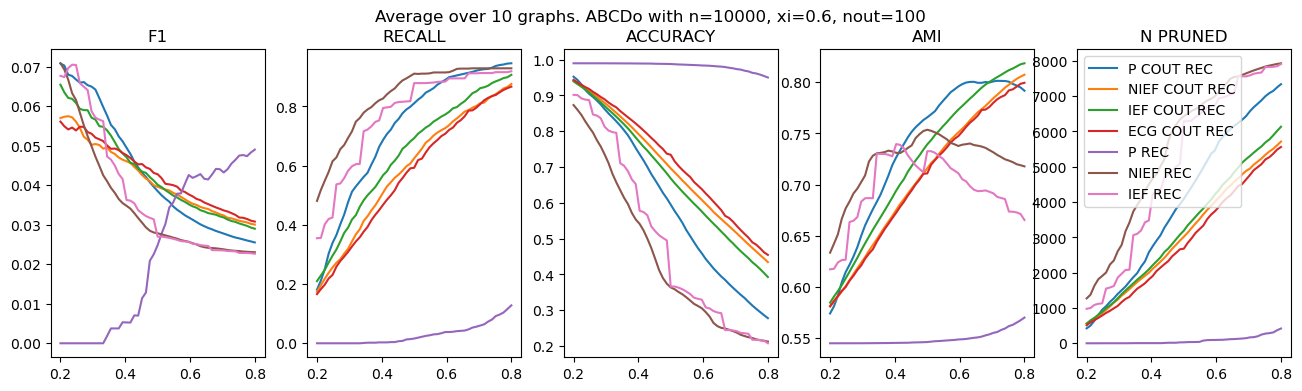

In [5]:
# Params
REP = 10
n = 10000
nout = int(n * 0.01)
xi = 0.6
cuts = np.linspace(0.2, 0.8, 51)

# Initialize results storage
pcout_pruned_rec = np.empty((REP, len(cuts), n), dtype="bool")
niefcout_pruned_rec = np.empty((REP, len(cuts), n), dtype="bool")
iefcout_pruned_rec = np.empty((REP, len(cuts), n), dtype="bool")
ecgcout_pruned_rec = np.empty((REP, len(cuts), n), dtype="bool")

pcout_pruned_one = np.empty((REP, len(cuts), n), dtype="bool")
niefcout_pruned_one = np.empty((REP, len(cuts), n), dtype="bool")
iefcout_pruned_one = np.empty((REP, len(cuts), n), dtype="bool")
ecgcout_pruned_one = np.empty((REP, len(cuts), n), dtype="bool")

p_pruned_rec = np.empty((REP, len(cuts), n), dtype="bool")
nief_pruned_rec = np.empty((REP, len(cuts), n), dtype="bool")
ief_pruned_rec = np.empty((REP, len(cuts), n), dtype="bool")

p_pruned_one = np.empty((REP, len(cuts), n), dtype="bool")
nief_pruned_one = np.empty((REP, len(cuts), n), dtype="bool")
ief_pruned_one = np.empty((REP, len(cuts), n), dtype="bool")

gts = np.empty((REP, n), dtype="int32")
com = np.empty((REP, n), dtype="int32")

# Compute
with tqdm(total=REP*len(cuts)) as pbar:
    for rep in range(REP):
        g, gt = _run_julia_abcd(n=n, xi=xi, nout=nout)
        gts[rep, :] = gt

        ief = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.ief_to_cluster)
        nief = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.nief_to_cluster)
        p = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.p_to_cluster)
        ecg = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.ecg_to_cluster)

        coms = ecg_sn.cluster_edges(g, p)
        com[rep, :] = coms

        for i, c in enumerate(cuts):
            iefcout_pruned_rec[rep, i, :] = ecg_sn.prune(g, coms, c, score="cout", edge_weights=ief)
            niefcout_pruned_rec[rep, i, :] = ecg_sn.prune(g, coms, c, score="cout", edge_weights=nief)
            pcout_pruned_rec[rep, i, :] = ecg_sn.prune(g, coms, c, score="cout", edge_weights=p)
            ecgcout_pruned_rec[rep, i, :] = ecg_sn.prune(g, coms, c, score="cout", edge_weights=ecg)

            iefcout_pruned_one[rep, i, :] = ecg_sn.prune(g, coms, c, score="cout", max_per_round=n, recursive=False, edge_weights=ief)
            niefcout_pruned_one[rep, i, :] = ecg_sn.prune(g, coms, c, score="cout", max_per_round=n, recursive=False, edge_weights=nief)
            pcout_pruned_one[rep, i, :] = ecg_sn.prune(g, coms, c, score="cout", max_per_round=n, recursive=False, edge_weights=p)
            ecgcout_pruned_one[rep, i, :] = ecg_sn.prune(g, coms, c, score="cout", max_per_round=n, recursive=False, edge_weights=ecg)

            ief_pruned_rec[rep, i, :] = ecg_sn.prune(g, coms, c, score="ief", max_per_round=100)
            nief_pruned_rec[rep, i, :] = ecg_sn.prune(g, coms, c, score="nief", max_per_round=100)
            p_pruned_rec[rep, i, :] = ecg_sn.prune(g, coms, c, score="p", max_per_round=100)

            ief_pruned_one[rep, i, :] = ecg_sn.prune(g, coms, c, score="ief", max_per_round=n, recursive=False)
            nief_pruned_one[rep, i, :] = ecg_sn.prune(g, coms, c, score="nief", max_per_round=n, recursive=False)
            p_pruned_one[rep, i, :] = ecg_sn.prune(g, coms, c, score="p", max_per_round=n, recursive=False)
        
            pbar.update()


###############
# Plot scores #
###############
def make_scores(score_function, pruned, gt, coms):
    results = np.empty((pruned.shape[0], pruned.shape[1]))
    for rep in range(pruned.shape[0]):
        is_outlier = gt[rep, :] == 0
        for i in range(pruned.shape[1]):
            results[rep, i] = score_function(is_outlier, pruned[rep, i, :])
    return results


def make_ami_scores(pruned, gt, coms):
    results = np.empty((pruned.shape[0], pruned.shape[1]))
    for rep in range(pruned.shape[0]):
        for i in range(pruned.shape[1]):
            is_outlier_or_pruned = np.bitwise_or(gt[rep, :] == 0, pruned[rep, i, :])
            results[rep, i] = AMI(gt[rep, :][~is_outlier_or_pruned], coms[rep, :][~is_outlier_or_pruned])
    return results


options = [
    [pcout_pruned_rec, "P COUT REC"],
    [niefcout_pruned_rec, "NIEF COUT REC"],
    [iefcout_pruned_rec, "IEF COUT REC"],
    [ecgcout_pruned_rec, "ECG COUT REC"],
    #[pcout_pruned_one, "P COUT"],
    #[niefcout_pruned_one, "NIEF COUT"],
    #[iefcout_pruned_one, "IEF COUT"],
    #[ecgcout_pruned_one, "ECG COUT"],
    [p_pruned_rec, "P REC"],
    [nief_pruned_rec, "NIEF REC"],
    [ief_pruned_rec, "IEF REC"],
    #[p_pruned_one, "P"],
    #[nief_pruned_one, "NIEF"],
    #[ief_pruned_one, "IEF"],
]
fig, axs = plt.subplots(1, 5, figsize=(16, 4))
for pruned, name in options:

    f1 = np.mean(make_scores(f1_score, pruned, gts, com), axis=0)
    recall = np.mean(make_scores(recall_score, pruned, gts, com), axis=0)
    accuracy = np.mean(make_scores(accuracy_score, pruned, gts, com), axis=0)
    ami = np.mean(make_ami_scores(pruned, gts, com), axis=0)

    axs[0].plot(cuts, f1, label=name)
    axs[0].set_title("F1")

    axs[1].plot(cuts, recall, label=name)
    axs[1].set_title("RECALL")

    axs[2].plot(cuts, accuracy, label=name)
    axs[2].set_title("ACCURACY")

    axs[3].plot(cuts, ami, label=name)
    axs[3].set_title("AMI")

    axs[4].plot(cuts, [np.sum(p) for p in pruned[rep, :, :]], label=name)
    axs[4].set_title("N PRUNED")
    axs[4].legend()
plt.suptitle(f"Average over {REP} graphs. ABCDo with n={n}, xi={xi}, nout={nout}")
print("Non-pruned AMI", AMI(gt[~gt], coms[~gt]))

100%|██████████| 510/510 [03:02<00:00,  2.80it/s]


Non-pruned AMI 0.8816523410657722


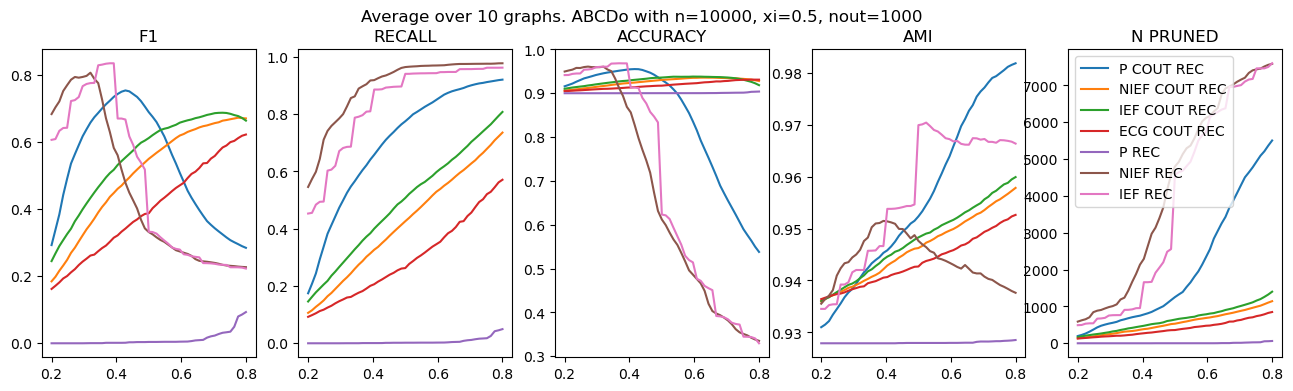

In [6]:
# Params
REP = 10
n = 10000
nout = int(n * 0.1)
xi = 0.50
cuts = np.linspace(0.2, 0.8, 51)

# Initialize results storage
pcout_pruned_rec = np.empty((REP, len(cuts), n), dtype="bool")
niefcout_pruned_rec = np.empty((REP, len(cuts), n), dtype="bool")
iefcout_pruned_rec = np.empty((REP, len(cuts), n), dtype="bool")
ecgcout_pruned_rec = np.empty((REP, len(cuts), n), dtype="bool")

pcout_pruned_one = np.empty((REP, len(cuts), n), dtype="bool")
niefcout_pruned_one = np.empty((REP, len(cuts), n), dtype="bool")
iefcout_pruned_one = np.empty((REP, len(cuts), n), dtype="bool")
ecgcout_pruned_one = np.empty((REP, len(cuts), n), dtype="bool")

p_pruned_rec = np.empty((REP, len(cuts), n), dtype="bool")
nief_pruned_rec = np.empty((REP, len(cuts), n), dtype="bool")
ief_pruned_rec = np.empty((REP, len(cuts), n), dtype="bool")

p_pruned_one = np.empty((REP, len(cuts), n), dtype="bool")
nief_pruned_one = np.empty((REP, len(cuts), n), dtype="bool")
ief_pruned_one = np.empty((REP, len(cuts), n), dtype="bool")

gts = np.empty((REP, n), dtype="int32")
com = np.empty((REP, n), dtype="int32")

# Compute
with tqdm(total=REP*len(cuts)) as pbar:
    for rep in range(REP):
        g, gt = _run_julia_abcd(n=n, xi=xi, nout=nout)
        gts[rep, :] = gt

        ief = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.ief_to_cluster)
        nief = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.nief_to_cluster)
        p = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.p_to_cluster)
        ecg = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.ecg_to_cluster)

        coms = ecg_sn.cluster_edges(g, p)
        com[rep, :] = coms

        for i, c in enumerate(cuts):
            iefcout_pruned_rec[rep, i, :] = ecg_sn.prune(g, coms, c, score="cout", edge_weights=ief)
            niefcout_pruned_rec[rep, i, :] = ecg_sn.prune(g, coms, c, score="cout", edge_weights=nief)
            pcout_pruned_rec[rep, i, :] = ecg_sn.prune(g, coms, c, score="cout", edge_weights=p)
            ecgcout_pruned_rec[rep, i, :] = ecg_sn.prune(g, coms, c, score="cout", edge_weights=ecg)

            iefcout_pruned_one[rep, i, :] = ecg_sn.prune(g, coms, c, score="cout", max_per_round=n, recursive=False, edge_weights=ief)
            niefcout_pruned_one[rep, i, :] = ecg_sn.prune(g, coms, c, score="cout", max_per_round=n, recursive=False, edge_weights=nief)
            pcout_pruned_one[rep, i, :] = ecg_sn.prune(g, coms, c, score="cout", max_per_round=n, recursive=False, edge_weights=p)
            ecgcout_pruned_one[rep, i, :] = ecg_sn.prune(g, coms, c, score="cout", max_per_round=n, recursive=False, edge_weights=ecg)

            ief_pruned_rec[rep, i, :] = ecg_sn.prune(g, coms, c, score="ief", max_per_round=100)
            nief_pruned_rec[rep, i, :] = ecg_sn.prune(g, coms, c, score="nief", max_per_round=100)
            p_pruned_rec[rep, i, :] = ecg_sn.prune(g, coms, c, score="p", max_per_round=100)

            ief_pruned_one[rep, i, :] = ecg_sn.prune(g, coms, c, score="ief", max_per_round=n, recursive=False)
            nief_pruned_one[rep, i, :] = ecg_sn.prune(g, coms, c, score="nief", max_per_round=n, recursive=False)
            p_pruned_one[rep, i, :] = ecg_sn.prune(g, coms, c, score="p", max_per_round=n, recursive=False)
        
            pbar.update()


###############
# Plot scores #
###############
def make_scores(score_function, pruned, gt, coms):
    results = np.empty((pruned.shape[0], pruned.shape[1]))
    for rep in range(pruned.shape[0]):
        is_outlier = gt[rep, :] == 0
        for i in range(pruned.shape[1]):
            results[rep, i] = score_function(is_outlier, pruned[rep, i, :])
    return results


def make_ami_scores(pruned, gt, coms):
    results = np.empty((pruned.shape[0], pruned.shape[1]))
    for rep in range(pruned.shape[0]):
        for i in range(pruned.shape[1]):
            is_outlier_or_pruned = np.bitwise_or(gt[rep, :] == 0, pruned[rep, i, :])
            results[rep, i] = AMI(gt[rep, :][~is_outlier_or_pruned], coms[rep, :][~is_outlier_or_pruned])
    return results


options = [
    [pcout_pruned_rec, "P COUT REC"],
    [niefcout_pruned_rec, "NIEF COUT REC"],
    [iefcout_pruned_rec, "IEF COUT REC"],
    [ecgcout_pruned_rec, "ECG COUT REC"],
    #[pcout_pruned_one, "P COUT"],
    #[niefcout_pruned_one, "NIEF COUT"],
    #[iefcout_pruned_one, "IEF COUT"],
    #[ecgcout_pruned_one, "ECG COUT"],
    [p_pruned_rec, "P REC"],
    [nief_pruned_rec, "NIEF REC"],
    [ief_pruned_rec, "IEF REC"],
    #[p_pruned_one, "P"],
    #[nief_pruned_one, "NIEF"],
    #[ief_pruned_one, "IEF"],
]
fig, axs = plt.subplots(1, 5, figsize=(16, 4))
for pruned, name in options:

    f1 = np.mean(make_scores(f1_score, pruned, gts, com), axis=0)
    recall = np.mean(make_scores(recall_score, pruned, gts, com), axis=0)
    accuracy = np.mean(make_scores(accuracy_score, pruned, gts, com), axis=0)
    ami = np.mean(make_ami_scores(pruned, gts, com), axis=0)

    axs[0].plot(cuts, f1, label=name)
    axs[0].set_title("F1")

    axs[1].plot(cuts, recall, label=name)
    axs[1].set_title("RECALL")

    axs[2].plot(cuts, accuracy, label=name)
    axs[2].set_title("ACCURACY")

    axs[3].plot(cuts, ami, label=name)
    axs[3].set_title("AMI")

    axs[4].plot(cuts, [np.sum(p) for p in pruned[rep, :, :]], label=name)
    axs[4].set_title("N PRUNED")
    axs[4].legend()
plt.suptitle(f"Average over {REP} graphs. ABCDo with n={n}, xi={xi}, nout={nout}")
print("Non-pruned AMI", AMI(gt[~gt], coms[~gt]))

In [27]:
# Params
REP = 10
n = 10000
nout = int(n * 0.1)
xi = 0.55
cuts = np.linspace(0.2, 0.8, 51)

# Initialize results storage
pcout_pruned_rec = np.empty((REP, len(cuts), n), dtype="bool")
niefcout_pruned_rec = np.empty((REP, len(cuts), n), dtype="bool")
iefcout_pruned_rec = np.empty((REP, len(cuts), n), dtype="bool")
ecgcout_pruned_rec = np.empty((REP, len(cuts), n), dtype="bool")

pcout_pruned_one = np.empty((REP, len(cuts), n), dtype="bool")
niefcout_pruned_one = np.empty((REP, len(cuts), n), dtype="bool")
iefcout_pruned_one = np.empty((REP, len(cuts), n), dtype="bool")
ecgcout_pruned_one = np.empty((REP, len(cuts), n), dtype="bool")

p_pruned_rec = np.empty((REP, len(cuts), n), dtype="bool")
nief_pruned_rec = np.empty((REP, len(cuts), n), dtype="bool")
ief_pruned_rec = np.empty((REP, len(cuts), n), dtype="bool")

p_pruned_one = np.empty((REP, len(cuts), n), dtype="bool")
nief_pruned_one = np.empty((REP, len(cuts), n), dtype="bool")
ief_pruned_one = np.empty((REP, len(cuts), n), dtype="bool")

gts = np.empty((REP, n), dtype="int32")
com = np.empty((REP, n), dtype="int32")

# Compute
with tqdm(total=REP*len(cuts)) as pbar:
    for rep in range(REP):
        g, gt = _run_julia_abcd(n=n, xi=xi, nout=nout)
        gts[rep, :] = gt

        ief = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.ief_to_cluster)
        nief = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.nief_to_cluster)
        p = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.p_to_cluster)
        ecg = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.ecg_to_cluster)

        coms = ecg_sn.cluster_edges(g, p)
        com[rep, :] = coms

        for i, c in enumerate(cuts):
            iefcout_pruned_rec[rep, i, :] = ecg_sn.prune(g, coms, c, score="cout", edge_weights=ief)
            niefcout_pruned_rec[rep, i, :] = ecg_sn.prune(g, coms, c, score="cout", edge_weights=nief)
            pcout_pruned_rec[rep, i, :] = ecg_sn.prune(g, coms, c, score="cout", edge_weights=p)
            ecgcout_pruned_rec[rep, i, :] = ecg_sn.prune(g, coms, c, score="cout", edge_weights=ecg)

            iefcout_pruned_one[rep, i, :] = ecg_sn.prune(g, coms, c, score="cout", max_per_round=n, recursive=False, edge_weights=ief)
            niefcout_pruned_one[rep, i, :] = ecg_sn.prune(g, coms, c, score="cout", max_per_round=n, recursive=False, edge_weights=nief)
            pcout_pruned_one[rep, i, :] = ecg_sn.prune(g, coms, c, score="cout", max_per_round=n, recursive=False, edge_weights=p)
            ecgcout_pruned_one[rep, i, :] = ecg_sn.prune(g, coms, c, score="cout", max_per_round=n, recursive=False, edge_weights=ecg)

            ief_pruned_rec[rep, i, :] = ecg_sn.prune(g, coms, c, score="ief", max_per_round=100)
            nief_pruned_rec[rep, i, :] = ecg_sn.prune(g, coms, c, score="nief", max_per_round=100)
            p_pruned_rec[rep, i, :] = ecg_sn.prune(g, coms, c, score="p", max_per_round=100)

            ief_pruned_one[rep, i, :] = ecg_sn.prune(g, coms, c, score="ief", max_per_round=n, recursive=False)
            nief_pruned_one[rep, i, :] = ecg_sn.prune(g, coms, c, score="nief", max_per_round=n, recursive=False)
            p_pruned_one[rep, i, :] = ecg_sn.prune(g, coms, c, score="p", max_per_round=n, recursive=False)
        
            pbar.update()


###############
# Plot scores #
###############
def make_scores(score_function, pruned, gt, coms):
    results = np.empty((pruned.shape[0], pruned.shape[1]))
    for rep in range(pruned.shape[0]):
        is_outlier = gt[rep, :] == 0
        for i in range(pruned.shape[1]):
            results[rep, i] = score_function(is_outlier, pruned[rep, i, :])
    return results


def make_ami_scores(pruned, gt, coms):
    results = np.empty((pruned.shape[0], pruned.shape[1]))
    for rep in range(pruned.shape[0]):
        for i in range(pruned.shape[1]):
            is_outlier_or_pruned = np.bitwise_or(gt[rep, :] == 0, pruned[rep, i, :])
            results[rep, i] = AMI(gt[rep, :][~is_outlier_or_pruned], coms[rep, :][~is_outlier_or_pruned])
    return results


options = [
    [pcout_pruned_rec, "P COUT REC"],
    [niefcout_pruned_rec, "NIEF COUT REC"],
    [iefcout_pruned_rec, "IEF COUT REC"],
    [ecgcout_pruned_rec, "ECG COUT REC"],
    #[pcout_pruned_one, "P COUT"],
    #[niefcout_pruned_one, "NIEF COUT"],
    #[iefcout_pruned_one, "IEF COUT"],
    #[ecgcout_pruned_one, "ECG COUT"],
    [p_pruned_rec, "P REC"],
    [nief_pruned_rec, "NIEF REC"],
    [ief_pruned_rec, "IEF REC"],
    #[p_pruned_one, "P"],
    #[nief_pruned_one, "NIEF"],
    #[ief_pruned_one, "IEF"],
]
fig, axs = plt.subplots(1, 5, figsize=(16, 4))
for pruned, name in options:

    f1 = np.mean(make_scores(f1_score, pruned, gts, com), axis=0)
    recall = np.mean(make_scores(recall_score, pruned, gts, com), axis=0)
    accuracy = np.mean(make_scores(accuracy_score, pruned, gts, com), axis=0)
    ami = np.mean(make_ami_scores(pruned, gts, com), axis=0)

    axs[0].plot(cuts, f1, label=name)
    axs[0].set_title("F1")

    axs[1].plot(cuts, recall, label=name)
    axs[1].set_title("RECALL")

    axs[2].plot(cuts, accuracy, label=name)
    axs[2].set_title("ACCURACY")

    axs[3].plot(cuts, ami, label=name)
    axs[3].set_title("AMI")

    axs[4].plot(cuts, [np.sum(p) for p in pruned[rep, :, :]], label=name)
    axs[4].set_title("N PRUNED")
    axs[4].legend()
plt.suptitle(f"Average over {REP} graphs. ABCDo with n={n}, xi={xi}, nout={nout}")
print("Non-pruned AMI", AMI(gt[~gt], coms[~gt]))

 50%|█████     | 255/510 [01:46<01:29,  2.83it/s]

100%|██████████| 510/510 [04:35<00:00,  1.85it/s]


Non-pruned AMI 0.7791733988337419


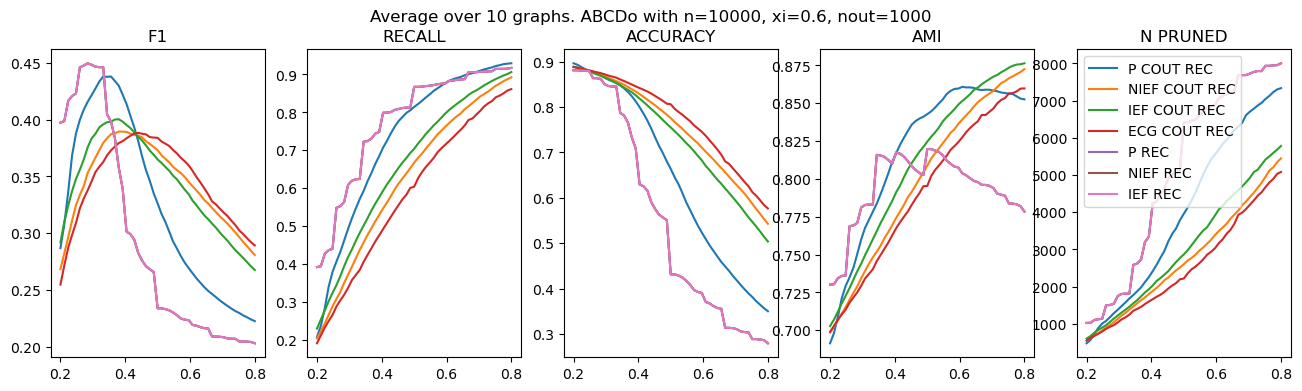

In [28]:
# Params
REP = 10
n = 10000
nout = int(n * 0.1)
xi = 0.6
cuts = np.linspace(0.2, 0.8, 51)

# Initialize results storage
pcout_pruned_rec = np.empty((REP, len(cuts), n), dtype="bool")
niefcout_pruned_rec = np.empty((REP, len(cuts), n), dtype="bool")
iefcout_pruned_rec = np.empty((REP, len(cuts), n), dtype="bool")
ecgcout_pruned_rec = np.empty((REP, len(cuts), n), dtype="bool")

pcout_pruned_one = np.empty((REP, len(cuts), n), dtype="bool")
niefcout_pruned_one = np.empty((REP, len(cuts), n), dtype="bool")
iefcout_pruned_one = np.empty((REP, len(cuts), n), dtype="bool")
ecgcout_pruned_one = np.empty((REP, len(cuts), n), dtype="bool")

p_pruned_rec = np.empty((REP, len(cuts), n), dtype="bool")
nief_pruned_rec = np.empty((REP, len(cuts), n), dtype="bool")
ief_pruned_rec = np.empty((REP, len(cuts), n), dtype="bool")

p_pruned_one = np.empty((REP, len(cuts), n), dtype="bool")
nief_pruned_one = np.empty((REP, len(cuts), n), dtype="bool")
ief_pruned_one = np.empty((REP, len(cuts), n), dtype="bool")

gts = np.empty((REP, n), dtype="int32")
com = np.empty((REP, n), dtype="int32")

# Compute
with tqdm(total=REP*len(cuts)) as pbar:
    for rep in range(REP):
        g, gt = _run_julia_abcd(n=n, xi=xi, nout=nout)
        gts[rep, :] = gt

        ief = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.ief_to_cluster)
        nief = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.nief_to_cluster)
        p = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.p_to_cluster)
        ecg = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.ecg_to_cluster)

        coms = ecg_sn.cluster_edges(g, p)
        com[rep, :] = coms

        for i, c in enumerate(cuts):
            iefcout_pruned_rec[rep, i, :] = ecg_sn.prune(g, coms, c, score="cout", edge_weights=ief)
            niefcout_pruned_rec[rep, i, :] = ecg_sn.prune(g, coms, c, score="cout", edge_weights=nief)
            pcout_pruned_rec[rep, i, :] = ecg_sn.prune(g, coms, c, score="cout", edge_weights=p)
            ecgcout_pruned_rec[rep, i, :] = ecg_sn.prune(g, coms, c, score="cout", edge_weights=ecg)

            iefcout_pruned_one[rep, i, :] = ecg_sn.prune(g, coms, c, score="cout", max_per_round=n, recursive=False, edge_weights=ief)
            niefcout_pruned_one[rep, i, :] = ecg_sn.prune(g, coms, c, score="cout", max_per_round=n, recursive=False, edge_weights=nief)
            pcout_pruned_one[rep, i, :] = ecg_sn.prune(g, coms, c, score="cout", max_per_round=n, recursive=False, edge_weights=p)
            ecgcout_pruned_one[rep, i, :] = ecg_sn.prune(g, coms, c, score="cout", max_per_round=n, recursive=False, edge_weights=ecg)

            ief_pruned_rec[rep, i, :] = ecg_sn.prune(g, coms, c, score="ief", max_per_round=100)
            nief_pruned_rec[rep, i, :] = ecg_sn.prune(g, coms, c, score="nief", max_per_round=100)
            p_pruned_rec[rep, i, :] = ecg_sn.prune(g, coms, c, score="p", max_per_round=100)

            ief_pruned_one[rep, i, :] = ecg_sn.prune(g, coms, c, score="ief", max_per_round=n, recursive=False)
            nief_pruned_one[rep, i, :] = ecg_sn.prune(g, coms, c, score="nief", max_per_round=n, recursive=False)
            p_pruned_one[rep, i, :] = ecg_sn.prune(g, coms, c, score="p", max_per_round=n, recursive=False)
        
            pbar.update()


###############
# Plot scores #
###############
def make_scores(score_function, pruned, gt, coms):
    results = np.empty((pruned.shape[0], pruned.shape[1]))
    for rep in range(pruned.shape[0]):
        is_outlier = gt[rep, :] == 0
        for i in range(pruned.shape[1]):
            results[rep, i] = score_function(is_outlier, pruned[rep, i, :])
    return results


def make_ami_scores(pruned, gt, coms):
    results = np.empty((pruned.shape[0], pruned.shape[1]))
    for rep in range(pruned.shape[0]):
        for i in range(pruned.shape[1]):
            is_outlier_or_pruned = np.bitwise_or(gt[rep, :] == 0, pruned[rep, i, :])
            results[rep, i] = AMI(gt[rep, :][~is_outlier_or_pruned], coms[rep, :][~is_outlier_or_pruned])
    return results


options = [
    [pcout_pruned_rec, "P COUT REC"],
    [niefcout_pruned_rec, "NIEF COUT REC"],
    [iefcout_pruned_rec, "IEF COUT REC"],
    [ecgcout_pruned_rec, "ECG COUT REC"],
    #[pcout_pruned_one, "P COUT"],
    #[niefcout_pruned_one, "NIEF COUT"],
    #[iefcout_pruned_one, "IEF COUT"],
    #[ecgcout_pruned_one, "ECG COUT"],
    [p_pruned_rec, "P REC"],
    [nief_pruned_rec, "NIEF REC"],
    [ief_pruned_rec, "IEF REC"],
    #[p_pruned_one, "P"],
    #[nief_pruned_one, "NIEF"],
    #[ief_pruned_one, "IEF"],
]
fig, axs = plt.subplots(1, 5, figsize=(16, 4))
for pruned, name in options:

    f1 = np.mean(make_scores(f1_score, pruned, gts, com), axis=0)
    recall = np.mean(make_scores(recall_score, pruned, gts, com), axis=0)
    accuracy = np.mean(make_scores(accuracy_score, pruned, gts, com), axis=0)
    ami = np.mean(make_ami_scores(pruned, gts, com), axis=0)

    axs[0].plot(cuts, f1, label=name)
    axs[0].set_title("F1")

    axs[1].plot(cuts, recall, label=name)
    axs[1].set_title("RECALL")

    axs[2].plot(cuts, accuracy, label=name)
    axs[2].set_title("ACCURACY")

    axs[3].plot(cuts, ami, label=name)
    axs[3].set_title("AMI")

    axs[4].plot(cuts, [np.sum(p) for p in pruned[rep, :, :]], label=name)
    axs[4].set_title("N PRUNED")
    axs[4].legend()
plt.suptitle(f"Average over {REP} graphs. ABCDo with n={n}, xi={xi}, nout={nout}")
print("Non-pruned AMI", AMI(gt[~gt], coms[~gt]))

In [29]:
# Params
REP = 10
n = 10000
nout = int(n * 0.4)
xi = 0.50
cuts = np.linspace(0.2, 0.8, 51)

# Initialize results storage
pcout_pruned_rec = np.empty((REP, len(cuts), n), dtype="bool")
niefcout_pruned_rec = np.empty((REP, len(cuts), n), dtype="bool")
iefcout_pruned_rec = np.empty((REP, len(cuts), n), dtype="bool")
ecgcout_pruned_rec = np.empty((REP, len(cuts), n), dtype="bool")

pcout_pruned_one = np.empty((REP, len(cuts), n), dtype="bool")
niefcout_pruned_one = np.empty((REP, len(cuts), n), dtype="bool")
iefcout_pruned_one = np.empty((REP, len(cuts), n), dtype="bool")
ecgcout_pruned_one = np.empty((REP, len(cuts), n), dtype="bool")

p_pruned_rec = np.empty((REP, len(cuts), n), dtype="bool")
nief_pruned_rec = np.empty((REP, len(cuts), n), dtype="bool")
ief_pruned_rec = np.empty((REP, len(cuts), n), dtype="bool")

p_pruned_one = np.empty((REP, len(cuts), n), dtype="bool")
nief_pruned_one = np.empty((REP, len(cuts), n), dtype="bool")
ief_pruned_one = np.empty((REP, len(cuts), n), dtype="bool")

gts = np.empty((REP, n), dtype="int32")
com = np.empty((REP, n), dtype="int32")

# Compute
with tqdm(total=REP*len(cuts)) as pbar:
    for rep in range(REP):
        g, gt = _run_julia_abcd(n=n, xi=xi, nout=nout)
        gts[rep, :] = gt

        ief = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.ief_to_cluster)
        nief = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.nief_to_cluster)
        p = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.p_to_cluster)
        ecg = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.ecg_to_cluster)

        coms = ecg_sn.cluster_edges(g, p)
        com[rep, :] = coms

        for i, c in enumerate(cuts):
            iefcout_pruned_rec[rep, i, :] = ecg_sn.prune(g, coms, c, score="cout", edge_weights=ief)
            niefcout_pruned_rec[rep, i, :] = ecg_sn.prune(g, coms, c, score="cout", edge_weights=nief)
            pcout_pruned_rec[rep, i, :] = ecg_sn.prune(g, coms, c, score="cout", edge_weights=p)
            ecgcout_pruned_rec[rep, i, :] = ecg_sn.prune(g, coms, c, score="cout", edge_weights=ecg)

            iefcout_pruned_one[rep, i, :] = ecg_sn.prune(g, coms, c, score="cout", max_per_round=n, recursive=False, edge_weights=ief)
            niefcout_pruned_one[rep, i, :] = ecg_sn.prune(g, coms, c, score="cout", max_per_round=n, recursive=False, edge_weights=nief)
            pcout_pruned_one[rep, i, :] = ecg_sn.prune(g, coms, c, score="cout", max_per_round=n, recursive=False, edge_weights=p)
            ecgcout_pruned_one[rep, i, :] = ecg_sn.prune(g, coms, c, score="cout", max_per_round=n, recursive=False, edge_weights=ecg)

            ief_pruned_rec[rep, i, :] = ecg_sn.prune(g, coms, c, score="ief", max_per_round=100)
            nief_pruned_rec[rep, i, :] = ecg_sn.prune(g, coms, c, score="nief", max_per_round=100)
            p_pruned_rec[rep, i, :] = ecg_sn.prune(g, coms, c, score="p", max_per_round=100)

            ief_pruned_one[rep, i, :] = ecg_sn.prune(g, coms, c, score="ief", max_per_round=n, recursive=False)
            nief_pruned_one[rep, i, :] = ecg_sn.prune(g, coms, c, score="nief", max_per_round=n, recursive=False)
            p_pruned_one[rep, i, :] = ecg_sn.prune(g, coms, c, score="p", max_per_round=n, recursive=False)
        
            pbar.update()


###############
# Plot scores #
###############
def make_scores(score_function, pruned, gt, coms):
    results = np.empty((pruned.shape[0], pruned.shape[1]))
    for rep in range(pruned.shape[0]):
        is_outlier = gt[rep, :] == 0
        for i in range(pruned.shape[1]):
            results[rep, i] = score_function(is_outlier, pruned[rep, i, :])
    return results


def make_ami_scores(pruned, gt, coms):
    results = np.empty((pruned.shape[0], pruned.shape[1]))
    for rep in range(pruned.shape[0]):
        for i in range(pruned.shape[1]):
            is_outlier_or_pruned = np.bitwise_or(gt[rep, :] == 0, pruned[rep, i, :])
            results[rep, i] = AMI(gt[rep, :][~is_outlier_or_pruned], coms[rep, :][~is_outlier_or_pruned])
    return results


options = [
    [pcout_pruned_rec, "P COUT REC"],
    [niefcout_pruned_rec, "NIEF COUT REC"],
    [iefcout_pruned_rec, "IEF COUT REC"],
    [ecgcout_pruned_rec, "ECG COUT REC"],
    #[pcout_pruned_one, "P COUT"],
    #[niefcout_pruned_one, "NIEF COUT"],
    #[iefcout_pruned_one, "IEF COUT"],
    #[ecgcout_pruned_one, "ECG COUT"],
    [p_pruned_rec, "P REC"],
    [nief_pruned_rec, "NIEF REC"],
    [ief_pruned_rec, "IEF REC"],
    #[p_pruned_one, "P"],
    #[nief_pruned_one, "NIEF"],
    #[ief_pruned_one, "IEF"],
]
fig, axs = plt.subplots(1, 5, figsize=(16, 4))
for pruned, name in options:

    f1 = np.mean(make_scores(f1_score, pruned, gts, com), axis=0)
    recall = np.mean(make_scores(recall_score, pruned, gts, com), axis=0)
    accuracy = np.mean(make_scores(accuracy_score, pruned, gts, com), axis=0)
    ami = np.mean(make_ami_scores(pruned, gts, com), axis=0)

    axs[0].plot(cuts, f1, label=name)
    axs[0].set_title("F1")

    axs[1].plot(cuts, recall, label=name)
    axs[1].set_title("RECALL")

    axs[2].plot(cuts, accuracy, label=name)
    axs[2].set_title("ACCURACY")

    axs[3].plot(cuts, ami, label=name)
    axs[3].set_title("AMI")

    axs[4].plot(cuts, [np.sum(p) for p in pruned[rep, :, :]], label=name)
    axs[4].set_title("N PRUNED")
    axs[4].legend()
plt.suptitle(f"Average over {REP} graphs. ABCDo with n={n}, xi={xi}, nout={nout}")
print("Non-pruned AMI", AMI(gt[~gt], coms[~gt]))

 33%|███▎      | 166/510 [01:24<02:54,  1.97it/s]


KeyboardInterrupt: 

In [ ]:
# Params
REP = 10
n = 10000
nout = int(n * 0.4)
xi = 0.55
cuts = np.linspace(0.2, 0.8, 51)

# Initialize results storage
pcout_pruned_rec = np.empty((REP, len(cuts), n), dtype="bool")
niefcout_pruned_rec = np.empty((REP, len(cuts), n), dtype="bool")
iefcout_pruned_rec = np.empty((REP, len(cuts), n), dtype="bool")
ecgcout_pruned_rec = np.empty((REP, len(cuts), n), dtype="bool")

pcout_pruned_one = np.empty((REP, len(cuts), n), dtype="bool")
niefcout_pruned_one = np.empty((REP, len(cuts), n), dtype="bool")
iefcout_pruned_one = np.empty((REP, len(cuts), n), dtype="bool")
ecgcout_pruned_one = np.empty((REP, len(cuts), n), dtype="bool")

p_pruned_rec = np.empty((REP, len(cuts), n), dtype="bool")
nief_pruned_rec = np.empty((REP, len(cuts), n), dtype="bool")
ief_pruned_rec = np.empty((REP, len(cuts), n), dtype="bool")

p_pruned_one = np.empty((REP, len(cuts), n), dtype="bool")
nief_pruned_one = np.empty((REP, len(cuts), n), dtype="bool")
ief_pruned_one = np.empty((REP, len(cuts), n), dtype="bool")

gts = np.empty((REP, n), dtype="int32")
com = np.empty((REP, n), dtype="int32")

# Compute
with tqdm(total=REP*len(cuts)) as pbar:
    for rep in range(REP):
        g, gt = _run_julia_abcd(n=n, xi=xi, nout=nout)
        gts[rep, :] = gt

        ief = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.ief_to_cluster)
        nief = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.nief_to_cluster)
        p = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.p_to_cluster)
        ecg = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.ecg_to_cluster)

        coms = ecg_sn.cluster_edges(g, p)
        com[rep, :] = coms

        for i, c in enumerate(cuts):
            iefcout_pruned_rec[rep, i, :] = ecg_sn.prune(g, coms, c, score="cout", edge_weights=ief)
            niefcout_pruned_rec[rep, i, :] = ecg_sn.prune(g, coms, c, score="cout", edge_weights=nief)
            pcout_pruned_rec[rep, i, :] = ecg_sn.prune(g, coms, c, score="cout", edge_weights=p)
            ecgcout_pruned_rec[rep, i, :] = ecg_sn.prune(g, coms, c, score="cout", edge_weights=ecg)

            iefcout_pruned_one[rep, i, :] = ecg_sn.prune(g, coms, c, score="cout", max_per_round=n, recursive=False, edge_weights=ief)
            niefcout_pruned_one[rep, i, :] = ecg_sn.prune(g, coms, c, score="cout", max_per_round=n, recursive=False, edge_weights=nief)
            pcout_pruned_one[rep, i, :] = ecg_sn.prune(g, coms, c, score="cout", max_per_round=n, recursive=False, edge_weights=p)
            ecgcout_pruned_one[rep, i, :] = ecg_sn.prune(g, coms, c, score="cout", max_per_round=n, recursive=False, edge_weights=ecg)

            ief_pruned_rec[rep, i, :] = ecg_sn.prune(g, coms, c, score="ief", max_per_round=100)
            nief_pruned_rec[rep, i, :] = ecg_sn.prune(g, coms, c, score="nief", max_per_round=100)
            p_pruned_rec[rep, i, :] = ecg_sn.prune(g, coms, c, score="p", max_per_round=100)

            ief_pruned_one[rep, i, :] = ecg_sn.prune(g, coms, c, score="ief", max_per_round=n, recursive=False)
            nief_pruned_one[rep, i, :] = ecg_sn.prune(g, coms, c, score="nief", max_per_round=n, recursive=False)
            p_pruned_one[rep, i, :] = ecg_sn.prune(g, coms, c, score="p", max_per_round=n, recursive=False)
        
            pbar.update()


###############
# Plot scores #
###############
def make_scores(score_function, pruned, gt, coms):
    results = np.empty((pruned.shape[0], pruned.shape[1]))
    for rep in range(pruned.shape[0]):
        is_outlier = gt[rep, :] == 0
        for i in range(pruned.shape[1]):
            results[rep, i] = score_function(is_outlier, pruned[rep, i, :])
    return results


def make_ami_scores(pruned, gt, coms):
    results = np.empty((pruned.shape[0], pruned.shape[1]))
    for rep in range(pruned.shape[0]):
        for i in range(pruned.shape[1]):
            is_outlier_or_pruned = np.bitwise_or(gt[rep, :] == 0, pruned[rep, i, :])
            results[rep, i] = AMI(gt[rep, :][~is_outlier_or_pruned], coms[rep, :][~is_outlier_or_pruned])
    return results


options = [
    [pcout_pruned_rec, "P COUT REC"],
    [niefcout_pruned_rec, "NIEF COUT REC"],
    [iefcout_pruned_rec, "IEF COUT REC"],
    [ecgcout_pruned_rec, "ECG COUT REC"],
    #[pcout_pruned_one, "P COUT"],
    #[niefcout_pruned_one, "NIEF COUT"],
    #[iefcout_pruned_one, "IEF COUT"],
    #[ecgcout_pruned_one, "ECG COUT"],
    [p_pruned_rec, "P REC"],
    [nief_pruned_rec, "NIEF REC"],
    [ief_pruned_rec, "IEF REC"],
    #[p_pruned_one, "P"],
    #[nief_pruned_one, "NIEF"],
    #[ief_pruned_one, "IEF"],
]
fig, axs = plt.subplots(1, 5, figsize=(16, 4))
for pruned, name in options:

    f1 = np.mean(make_scores(f1_score, pruned, gts, com), axis=0)
    recall = np.mean(make_scores(recall_score, pruned, gts, com), axis=0)
    accuracy = np.mean(make_scores(accuracy_score, pruned, gts, com), axis=0)
    ami = np.mean(make_ami_scores(pruned, gts, com), axis=0)

    axs[0].plot(cuts, f1, label=name)
    axs[0].set_title("F1")

    axs[1].plot(cuts, recall, label=name)
    axs[1].set_title("RECALL")

    axs[2].plot(cuts, accuracy, label=name)
    axs[2].set_title("ACCURACY")

    axs[3].plot(cuts, ami, label=name)
    axs[3].set_title("AMI")

    axs[4].plot(cuts, [np.sum(p) for p in pruned[rep, :, :]], label=name)
    axs[4].set_title("N PRUNED")
    axs[4].legend()
plt.suptitle(f"Average over {REP} graphs. ABCDo with n={n}, xi={xi}, nout={nout}")
print("Non-pruned AMI", AMI(gt[~gt], coms[~gt]))

In [ ]:
# Params
REP = 10
n = 10000
nout = int(n * 0.4)
xi = 0.6
cuts = np.linspace(0.2, 0.8, 51)

# Initialize results storage
pcout_pruned_rec = np.empty((REP, len(cuts), n), dtype="bool")
niefcout_pruned_rec = np.empty((REP, len(cuts), n), dtype="bool")
iefcout_pruned_rec = np.empty((REP, len(cuts), n), dtype="bool")
ecgcout_pruned_rec = np.empty((REP, len(cuts), n), dtype="bool")

pcout_pruned_one = np.empty((REP, len(cuts), n), dtype="bool")
niefcout_pruned_one = np.empty((REP, len(cuts), n), dtype="bool")
iefcout_pruned_one = np.empty((REP, len(cuts), n), dtype="bool")
ecgcout_pruned_one = np.empty((REP, len(cuts), n), dtype="bool")

p_pruned_rec = np.empty((REP, len(cuts), n), dtype="bool")
nief_pruned_rec = np.empty((REP, len(cuts), n), dtype="bool")
ief_pruned_rec = np.empty((REP, len(cuts), n), dtype="bool")

p_pruned_one = np.empty((REP, len(cuts), n), dtype="bool")
nief_pruned_one = np.empty((REP, len(cuts), n), dtype="bool")
ief_pruned_one = np.empty((REP, len(cuts), n), dtype="bool")

gts = np.empty((REP, n), dtype="int32")
com = np.empty((REP, n), dtype="int32")

# Compute
with tqdm(total=REP*len(cuts)) as pbar:
    for rep in range(REP):
        g, gt = _run_julia_abcd(n=n, xi=xi, nout=nout)
        gts[rep, :] = gt

        ief = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.ief_to_cluster)
        nief = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.nief_to_cluster)
        p = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.p_to_cluster)
        ecg = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.ecg_to_cluster)

        coms = ecg_sn.cluster_edges(g, p)
        com[rep, :] = coms

        for i, c in enumerate(cuts):
            iefcout_pruned_rec[rep, i, :] = ecg_sn.prune(g, coms, c, score="cout", edge_weights=ief)
            niefcout_pruned_rec[rep, i, :] = ecg_sn.prune(g, coms, c, score="cout", edge_weights=nief)
            pcout_pruned_rec[rep, i, :] = ecg_sn.prune(g, coms, c, score="cout", edge_weights=p)
            ecgcout_pruned_rec[rep, i, :] = ecg_sn.prune(g, coms, c, score="cout", edge_weights=ecg)

            iefcout_pruned_one[rep, i, :] = ecg_sn.prune(g, coms, c, score="cout", max_per_round=n, recursive=False, edge_weights=ief)
            niefcout_pruned_one[rep, i, :] = ecg_sn.prune(g, coms, c, score="cout", max_per_round=n, recursive=False, edge_weights=nief)
            pcout_pruned_one[rep, i, :] = ecg_sn.prune(g, coms, c, score="cout", max_per_round=n, recursive=False, edge_weights=p)
            ecgcout_pruned_one[rep, i, :] = ecg_sn.prune(g, coms, c, score="cout", max_per_round=n, recursive=False, edge_weights=ecg)

            ief_pruned_rec[rep, i, :] = ecg_sn.prune(g, coms, c, score="ief", max_per_round=100)
            nief_pruned_rec[rep, i, :] = ecg_sn.prune(g, coms, c, score="nief", max_per_round=100)
            p_pruned_rec[rep, i, :] = ecg_sn.prune(g, coms, c, score="p", max_per_round=100)

            ief_pruned_one[rep, i, :] = ecg_sn.prune(g, coms, c, score="ief", max_per_round=n, recursive=False)
            nief_pruned_one[rep, i, :] = ecg_sn.prune(g, coms, c, score="nief", max_per_round=n, recursive=False)
            p_pruned_one[rep, i, :] = ecg_sn.prune(g, coms, c, score="p", max_per_round=n, recursive=False)
        
            pbar.update()


###############
# Plot scores #
###############
def make_scores(score_function, pruned, gt, coms):
    results = np.empty((pruned.shape[0], pruned.shape[1]))
    for rep in range(pruned.shape[0]):
        is_outlier = gt[rep, :] == 0
        for i in range(pruned.shape[1]):
            results[rep, i] = score_function(is_outlier, pruned[rep, i, :])
    return results


def make_ami_scores(pruned, gt, coms):
    results = np.empty((pruned.shape[0], pruned.shape[1]))
    for rep in range(pruned.shape[0]):
        for i in range(pruned.shape[1]):
            is_outlier_or_pruned = np.bitwise_or(gt[rep, :] == 0, pruned[rep, i, :])
            results[rep, i] = AMI(gt[rep, :][~is_outlier_or_pruned], coms[rep, :][~is_outlier_or_pruned])
    return results


options = [
    [pcout_pruned_rec, "P COUT REC"],
    [niefcout_pruned_rec, "NIEF COUT REC"],
    [iefcout_pruned_rec, "IEF COUT REC"],
    [ecgcout_pruned_rec, "ECG COUT REC"],
    #[pcout_pruned_one, "P COUT"],
    #[niefcout_pruned_one, "NIEF COUT"],
    #[iefcout_pruned_one, "IEF COUT"],
    #[ecgcout_pruned_one, "ECG COUT"],
    [p_pruned_rec, "P REC"],
    [nief_pruned_rec, "NIEF REC"],
    [ief_pruned_rec, "IEF REC"],
    #[p_pruned_one, "P"],
    #[nief_pruned_one, "NIEF"],
    #[ief_pruned_one, "IEF"],
]
fig, axs = plt.subplots(1, 5, figsize=(16, 4))
for pruned, name in options:

    f1 = np.mean(make_scores(f1_score, pruned, gts, com), axis=0)
    recall = np.mean(make_scores(recall_score, pruned, gts, com), axis=0)
    accuracy = np.mean(make_scores(accuracy_score, pruned, gts, com), axis=0)
    ami = np.mean(make_ami_scores(pruned, gts, com), axis=0)

    axs[0].plot(cuts, f1, label=name)
    axs[0].set_title("F1")

    axs[1].plot(cuts, recall, label=name)
    axs[1].set_title("RECALL")

    axs[2].plot(cuts, accuracy, label=name)
    axs[2].set_title("ACCURACY")

    axs[3].plot(cuts, ami, label=name)
    axs[3].set_title("AMI")

    axs[4].plot(cuts, [np.sum(p) for p in pruned[rep, :, :]], label=name)
    axs[4].set_title("N PRUNED")
    axs[4].legend()
plt.suptitle(f"Average over {REP} graphs. ABCDo with n={n}, xi={xi}, nout={nout}")
print("Non-pruned AMI", AMI(gt[~gt], coms[~gt]))

0.8863032533999718


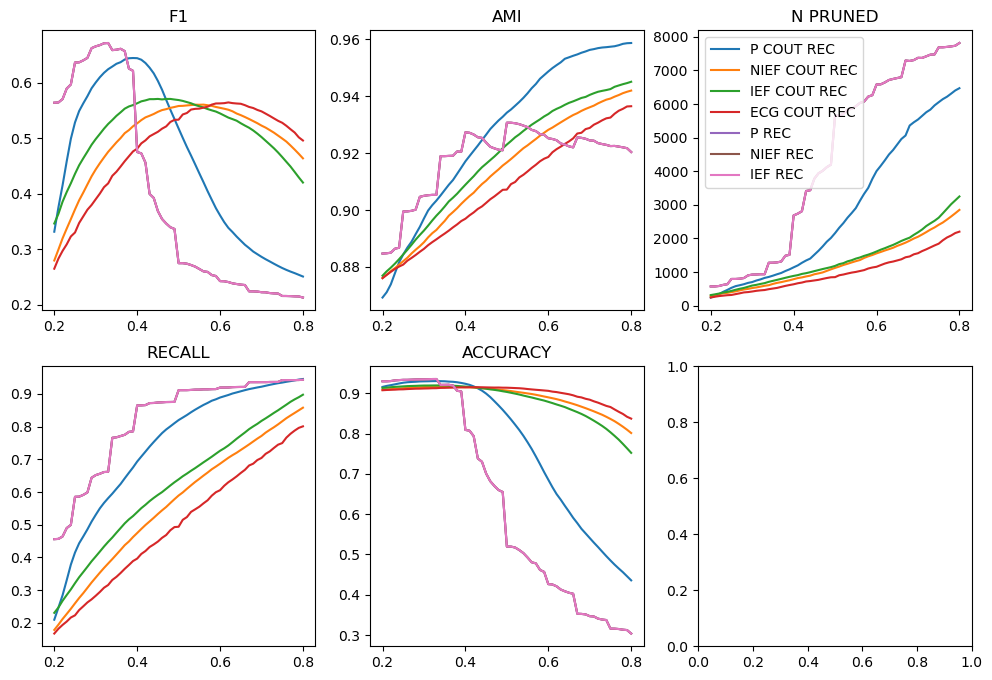

In [22]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8))


def make_scores(score_function, pruned, gt, coms):
    results = np.empty((pruned.shape[0], pruned.shape[1]))
    for rep in range(pruned.shape[0]):
        is_outlier = gt[rep, :] == 0
        for i in range(pruned.shape[1]):
            results[rep, i] = score_function(is_outlier, pruned[rep, i, :])
    return results


def make_ami_scores(pruned, gt, coms):
    results = np.empty((pruned.shape[0], pruned.shape[1]))
    for rep in range(pruned.shape[0]):
        for i in range(pruned.shape[1]):
            is_outlier_or_pruned = np.bitwise_or(gt[rep, :] == 0, pruned[rep, i, :])
            results[rep, i] = AMI(gt[rep, :][~is_outlier_or_pruned], coms[rep, :][~is_outlier_or_pruned])
    return results


options = [
    [pcout_pruned_rec, "P COUT REC"],
    [niefcout_pruned_rec, "NIEF COUT REC"],
    [iefcout_pruned_rec, "IEF COUT REC"],
    [ecgcout_pruned_rec, "ECG COUT REC"],
    #[pcout_pruned_one, "P COUT"],
    #[niefcout_pruned_one, "NIEF COUT"],
    #[iefcout_pruned_one, "IEF COUT"],
    #[ecgcout_pruned_one, "ECG COUT"],
    [p_pruned_rec, "P REC"],
    [nief_pruned_rec, "NIEF REC"],
    [ief_pruned_rec, "IEF REC"],
    #[p_pruned_one, "P"],
    #[nief_pruned_one, "NIEF"],
    #[ief_pruned_one, "IEF"],
]

for pruned, name in options:

    f1 = np.mean(make_scores(f1_score, pruned, gts, com), axis=0)
    recall = np.mean(make_scores(recall_score, pruned, gts, com), axis=0)
    accuracy = np.mean(make_scores(accuracy_score, pruned, gts, com), axis=0)
    ami = np.mean(make_ami_scores(pruned, gts, com), axis=0)

    axs[0, 0].plot(cuts, f1, label=name)
    axs[0, 0].set_title("F1")

    axs[1, 0].plot(cuts, recall, label=name)
    axs[1, 0].set_title("RECALL")

    axs[1, 1].plot(cuts, accuracy, label=name)
    axs[1, 1].set_title("ACCURACY")

    axs[0, 1].plot(cuts, ami, label=name)
    axs[0, 1].set_title("AMI")

    axs[0, 2].plot(cuts, [np.sum(p) for p in pruned[rep, :, :]], label=name)
    axs[0, 2].set_title("N PRUNED")
    axs[0, 2].legend()

print(AMI(gt[~gt], coms[~gt]))


## Consider Testing
I think it's fine to only consider the simplest pruning strategy.
Either (a) one shot prune below threshhold, or (b) multiround prune while below threshhold
(a) takes a threshhold parameter
(b) takes a threshhold parameter, and a max prunes per round parameter (which can perhaps be automatically guess assuming we want something like 10 rounds).

1. ABCDo range of usable F1 scores for predicting outliers. Test each score with each pruning method.
2. Real graphs (SNAP), probably considering noise as not in a strong commuity (given by strongtest community labels available)

A test, how well it could do can be measured by the max F1 score.
Maybe we consider viable parameter options anything within 10% of the max F1 score.

Hopefully at least one pair of score/method shows enough promise with some parameters to be considered usable.


Try on real graphs from SNAP instead of a big and costly simulation. (SNAP is too big for this laptop. Consider running with more RAM or using sn version)

In [186]:
g = ig.Graph.Read_GML("real_data/as.gml")
g = g.as_undirected()
g.vcount()

23752

In [198]:
# # For loading npz graphs
# with np.load("real_data/fb_0.npz", allow_pickle=True) as loader:
#     loader = dict(loader)
# A = sparse.csr_matrix((loader['adj_matrix.data'], loader['adj_matrix.indices'],
#                     loader['adj_matrix.indptr']), shape=loader['adj_matrix.shape'], dtype="int32")

# Z = sparse.csr_matrix((loader['labels.data'], loader['labels.indices'],
#                     loader['labels.indptr']), shape=loader['labels.shape'])

# # Remove self-loops
# A = A.tolil()
# A.setdiag(0)
# A = A.tocsr()

# g = A

In [208]:
p = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.p_to_cluster)
coms = ecg_sn.cluster_edges(g, p)

ecg = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.ecg_to_cluster)
ecg_coms = ecg_sn.cluster_edges(g, ecg)

In [209]:
%%time
c = 0.8
pruned = ecg_sn.prune(g, coms, c, score="cout", max_per_round=100, edge_weights=p)

print(np.sum(pruned), " of ", g.shape[0], " nodes pruned")

94  of  347  nodes pruned
CPU times: user 1.19 ms, sys: 0 ns, total: 1.19 ms
Wall time: 1 ms


In [210]:
#print("Louvian AMI", AMI(gt, g.community_multilevel().membership))
print("ECG     AMI", AMI(gt, ecg_coms))
print("P       AMI", AMI(gt, coms))
print("Pruned  AMI", AMI(gt[~pruned], coms[~pruned]))


ValueError: Found input variables with inconsistent numbers of samples: [23752, 347]

In [194]:
%%time
ief = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.ief_to_cluster)
nief = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.nief_to_cluster)
p = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.p_to_cluster)
ecg = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.ecg_to_cluster)


cuts = np.linspace(0.2, 0.95, 61)
pcout_pruned_rec = []
niefcout_pruned_rec = []
iefcout_pruned_rec = []
ecgcout_pruned_rec = []

p_pruned_rec = []
nief_pruned_rec = []
ief_pruned_rec = []

for c in tqdm(cuts):
    iefcout_pruned_rec.append(ecg_sn.prune(g, coms, c, score="cout", edge_weights=ief))
    niefcout_pruned_rec.append(ecg_sn.prune(g, coms, c, score="cout", edge_weights=nief))
    pcout_pruned_rec.append(ecg_sn.prune(g, coms, c, score="cout", edge_weights=p))
    ecgcout_pruned_rec.append(ecg_sn.prune(g, coms, c, score="cout", edge_weights=ecg))

    ief_pruned_rec.append(ecg_sn.prune(g, coms, c, score="ief", max_per_round=100))
    nief_pruned_rec.append(ecg_sn.prune(g, coms, c, score="nief", max_per_round=100))
    p_pruned_rec.append(ecg_sn.prune(g, coms, c, score="p", max_per_round=100))

100%|██████████| 61/61 [00:20<00:00,  2.92it/s]

CPU times: user 27.2 s, sys: 7.95 ms, total: 27.2 s
Wall time: 27.2 s


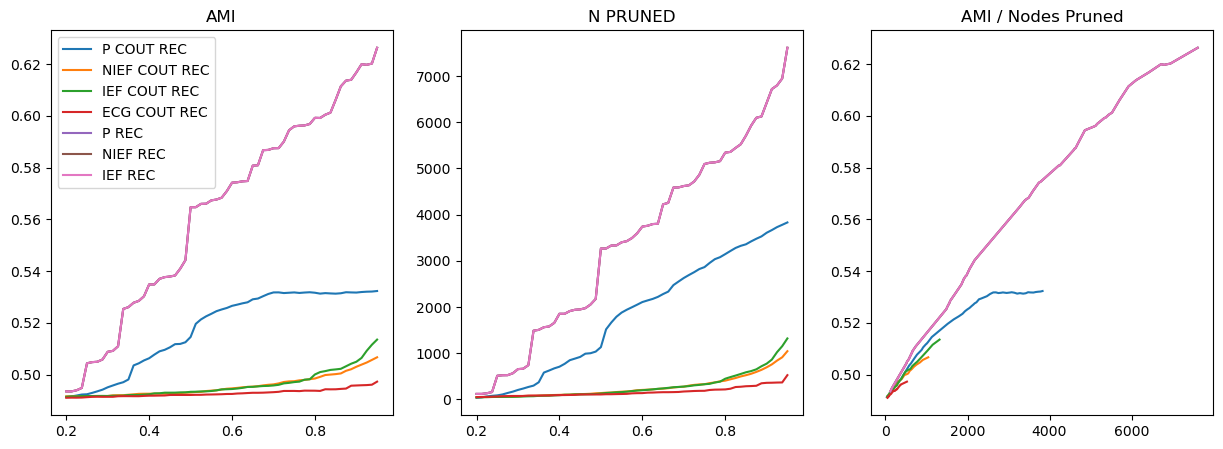

In [195]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
options = [
    [pcout_pruned_rec, "P COUT REC"],
    [niefcout_pruned_rec, "NIEF COUT REC"],
    [iefcout_pruned_rec, "IEF COUT REC"],
    [ecgcout_pruned_rec, "ECG COUT REC"],
    [p_pruned_rec, "P REC"],
    [nief_pruned_rec, "NIEF REC"],
    [ief_pruned_rec, "IEF REC"],
]
for pruned, name in options:
    axs[0].plot(cuts, [AMI(gt[~p], coms[~p]) for p in pruned], label=name)
    axs[1].plot(cuts, [np.sum(p) for p in pruned], label=name)
    axs[2].plot([np.sum(p) for p in pruned], [AMI(gt[~p], coms[~p]) for p in pruned], label=name)
    
axs[0].set_title("AMI")
axs[1].set_title("N PRUNED")
axs[2].set_title("AMI / Nodes Pruned")
axs[0].legend()